<a href="https://colab.research.google.com/github/Seongjin1225/AI_SCHOOL_9/blob/main/ML%26DL/12%EC%9B%94%2018%EC%9D%BC/12%EC%9B%94_18%EC%9D%BC_%EB%B3%B5%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
x_data의 shape : (20, 150, 150, 3)
t_data의 shape : (20,)


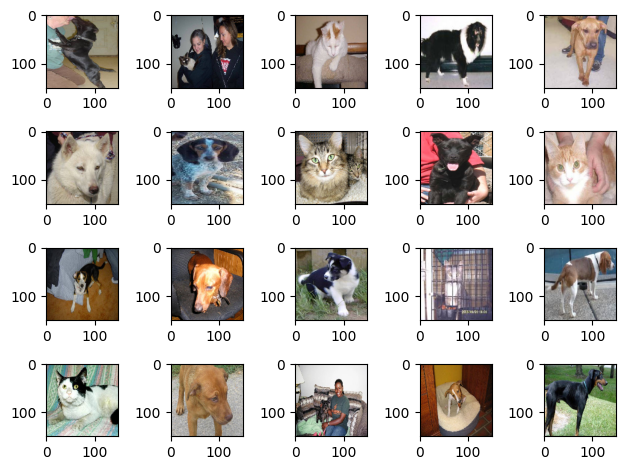

In [ ]:
# 데이터를 가져오기 위해
# keras에서 제공하는 ImageDataGenerator를 사용할 거에요!

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 학습하기위해서는 train data와 validation data가 필요
# 지금까지는 학습할때 train data 중 일부(30%)를 띄어서 validation에 사용
# 이렇게 해도 되지만 아예 validation data를 별도로 사용 가능!
train_dir = '/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/train'
validation_dir = '/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/validation'

# ImageDataGenerator 생성
# 각 픽셀 값은 0~255 사이의 값을 가짐
# rescale을 통해 정규화 가능
train_gen = ImageDataGenerator(rescale= 1/255)
validation_gen = ImageDataGenerator(rescale= 1/255)

train_generator = train_gen.flow_from_directory(
    train_dir,  # 이미지 가져올 폴더 설정
    classes=['cats','dogs'],  # 폴더명 명시, 순서대로 label 값 생성됨(고양이=0, 개=1)
    target_size=(150,150),  # 이미지 사이즈 설정
    batch_size = 20,  # 한번에 몇개의 데이터 가져올지 설정
    class_mode = 'binary'  # 이진분류 이므로 binary, 다중분류일때는 categorial
)

validation_generator = validation_gen.flow_from_directory(
    validation_dir,
    classes=['cats','dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

# generator를 만들었으니 잘 동작하는지 확인하기!
for x_data, t_data in train_generator:
    print(f'x_data의 shape : {x_data.shape}')
    print(f't_data의 shape : {t_data.shape}')
    break

# 가져온 픽셀 데이터가 진짜 이미지의 픽셀 데이터인지 확인!
# 픽셀 데이터를 이용해 그림을 그려보면 되겠죠!
# enumerate 사용시, 맨 앞, 나머지로 분리 ->
# 여기서는 (20,150,150,3)이 idx = 20, img_data = (150,150,3) 이렇게
fig = plt.figure()
axs = []

for i in range(20):
    axs.append(fig.add_subplot(4,5,i+1))
for x_data, t_data in train_generator:
    for idx, img_data in enumerate(x_data):
        axs[idx].imshow(img_data)
    break

plt.tight_layout()
plt.show()

In [ ]:
# generator를 생성했으니 model을 만들 차례
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 input_shape=(150,150,3)))
                 # filter의 shape => (3,3,3,32) 필터의 channel은 입력 데이터의 channel과 동일
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

# model.summary()

# FC Layer(DNN 학습) - input, hidden, output 부분
model.add(Flatten())  # 4차원을 펴준다는 의미

# hidden layer(선택사항)
# 1개만 넣어도 되고 여러개 넣어도 되고 안넣어도 됨!!
model.add(Dense(units=512,
                activation='relu'))

# output layer
model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# 모델을 생성했으니 학습하기 - 이 부분이 좀 다르다

# 우선, 조기종료 설정
from tensorflow.keras.callbacks import EarlyStopping
es_cb = EarlyStopping(monitor='val_loss',
                      patience=5,
                      restore_best_weights=True)

# 학습 데이터와 val 데이터는 각각 generator 안에 있음
# 학습 데이터의 경우 한번에 20개 불러옴 but 한 epoch당 총 개수인 2000개 학습 필요
# 20*100 = 2000이므로 steps_per_epoch = 100
# validation_steps 역시 위와 동일, val 데이터는 총 1000개
# 따라서 20*50 = 1000이므로 validation_step = 50
model.fit(train_generator,
          steps_per_epoch=100,  # 한 epoch 당 generator를 몇 번 실행할 것인지
          epochs=50,
          validation_data = validation_generator,
          validation_steps = 50,
          callbacks=[es_cb],
          verbose=1
          )

# Epoch 12/50
# 100/100 [==============================] - 9s 89ms/step - loss: 0.1033 - acc: 0.9660 - val_loss: 0.9144 - val_acc: 0.7080
# 정확도가 70% 정도 -> 사용할 수 없는 모델이라는 의미
# 둘 중 하나 고르는건데도 10개 중 7개만 맞는거면 뭐..

Epoch 1/50
100/100 [==============================] - 1067s 11s/step - loss: 0.6800 - acc: 0.5640 - val_loss: 0.6468 - val_acc: 0.6080
Epoch 2/50
100/100 [==============================] - 11s 113ms/step - loss: 0.6021 - acc: 0.6770 - val_loss: 0.5954 - val_acc: 0.6940
Epoch 3/50
100/100 [==============================] - 9s 88ms/step - loss: 0.5224 - acc: 0.7390 - val_loss: 0.5784 - val_acc: 0.6930
Epoch 4/50
100/100 [==============================] - 10s 104ms/step - loss: 0.4578 - acc: 0.7835 - val_loss: 0.5770 - val_acc: 0.7000
Epoch 5/50
100/100 [==============================] - 11s 112ms/step - loss: 0.4255 - acc: 0.8000 - val_loss: 0.5983 - val_acc: 0.7020
Epoch 6/50
100/100 [==============================] - 9s 91ms/step - loss: 0.3592 - acc: 0.8475 - val_loss: 0.5868 - val_acc: 0.7100
Epoch 7/50
100/100 [==============================] - 10s 105ms/step - loss: 0.3195 - acc: 0.8655 - val_loss: 0.5766 - val_acc: 0.7210
Epoch 8/50
100/100 [==============================] - 10s 9

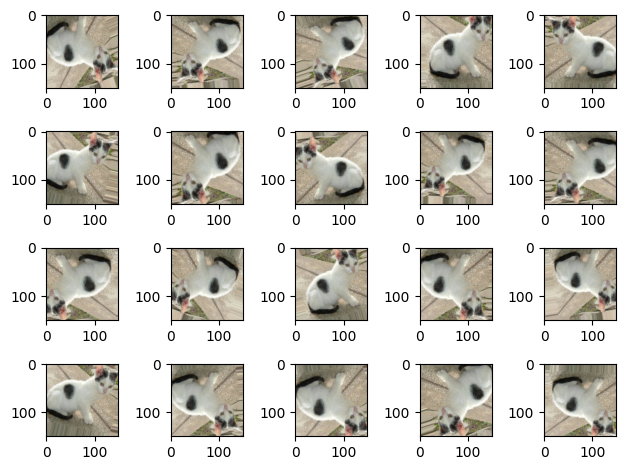

In [ ]:
# Image Augmentation(이미지 증식)
# 데이터를 살짝 변형시켜 데이터를 늘려서 학습을 시키는 것
# 주의점!! 살짝 변형시키는 것이지 새로운 데이터를 만들어내는 것은 아님
# 회전, 이미지 이동, 확대/축소, Flip

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(rescale=1/255,
                             rotation_range=20,  # 회전 각도 범위 설정(0~20 사이 값 랜덤하게 실행됨)
                             width_shift_range = 0.1,  # 0.1 = 10%
                             height_shift_range=0.1,
                             shear_range = 0.1,
                             zoom_range=0.1,
                             horizontal_flip = True,
                             vertical_flip=True,
                             fill_mode='nearest'
                             )
# width_shift_range = 가로 방향 얼만큼 움직일지(왼쪽 or 오른쪽),
img = image.load_img('/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/train/cats/cat.3.jpg',
                     target_size=(150,150))
x = image.img_to_array(img)
x.shape

# ImageGenerator를 이용해서 이 파일로부터 증식된 이미지를 추출!
# 기본적으로 ImageDataGenerator는 4차원을 사용
# 우리 이미지도 역시 4차원으로 표현해야!
x = x.reshape((1,) + x.shape)
x.shape

# 직접 그려서 확인
fig = plt.figure()
axs = []
for i in range(20):
    axs.append(fig.add_subplot(4,5,i+1))

idx=0
for batch in datagen.flow(x,batch_size=1):
    axs[idx].imshow(image.array_to_img(batch[0]))  # batch[0]는 픽셀 데이터(변형된 이미지)
    idx += 1
    if idx%20==0:
        break

plt.tight_layout()
plt.show()

In [ ]:
# 우리가 가진 얼마안되는 데이터(학습 데이터 개와 고양이 2000장)
# 증식기법을 이용해서 변경된 이미지를 이용해서 학습데이터 수를 늘리고
# dropout 기법 활용해서 Overfitting을 줄이기

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/train'
validation_dir = '/content/drive/MyDrive/AI스쿨 파일/ML/cat_dog_small/validation'

# ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# validation data는 증식을 사용하면 안되요! (평가용 데이터이기 때문)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

# model 생성

model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 input_shape=(150,150,3)))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

# 여기까지가 Feature Extraction 부분이에요! 이미지의 특징을 추출하는 부분
# 이렇게 이미지의 특징을 추출한 후 2차원으로 변경해서 학습을 진행

model.add(Flatten())  # 4차원데이터를 2차원으로 변경(이미지 3차원을 1차원으로 변경)

model.add(Dropout(rate=0.5))

# hidden layer
model.add(Dense(units=512,
                activation='relu'))

# output layer
model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

# overfitting 정도를 확인하기 위해 EarlyStopping은 설정하지 않았어요!
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 720s 7s/step - loss: 0.6925 - acc: 0.5115 - val_loss: 0.6870 - val_acc: 0.5490
Epoch 2/100
100/100 [==============================] - 23s 231ms/step - loss: 0.6919 - acc: 0.5205 - val_loss: 0.6807 - val_acc: 0.5690
Epoch 3/100
100/100 [==============================] - 25s 253ms/step - loss: 0.6795 - acc: 0.5645 - val_loss: 0.6514 - val_acc: 0.6080
Epoch 4/100
100/100 [==============================] - 21s 207ms/step - loss: 0.6465 - acc: 0.6130 - val_loss: 0.6123 - val_acc: 0.6650
Epoch 5/100
100/100 [==============================] - 20s 203ms/step - loss: 0.6105 - acc: 0.6715 - val_loss: 0.5757 - val_acc: 0.6930
Epoch 6/100
100/100 [==============================] - 22s 224ms/step - loss: 0.6010 - acc: 0.6705 - val_loss: 0.5793 - val_acc: 0.6870
Epoch 7/100
100/100 [==============================] - 20s 204ms/step - loss: 0.5820 - acc: 0.7080 - v

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['acc']
valid_acc = history.history['val_acc']

plt.plot(train_loss, color='r')
plt.plot(valid_loss, color='b')
plt.show()

plt.plot(train_acc, color='r')
plt.plot(valid_acc, color='b')
plt.show()